# Exercise 2

**Please Note**: We updated the requirements.txt

Please install the new requirements before editing this exercise.

## Import packages

In [5]:
import os

from vll.utils.download import download_mnist
import numpy as np
import matplotlib.pyplot as plt

import skimage
import skimage.io

import torch
import torch.nn.functional as F
from torchvision import transforms

from models.mnist.simple_cnn import Net

## Task 1
(2 points)

In this task, you will learn some basic tensor operations using the PyTorch library.

Reference for torch: https://pytorch.org/docs/stable/torch.html

In [7]:
# Create a numpy array that looks like this: [0, 1, 2, ..., 19]
arr = np.array([0, 1, 2, 3, 4])

# Convert the numpy array to a torch tensor
tensor = torch.from_numpy(arr)
print(tensor)

# Create a tensor that contains random numbers.
# It should have the same size like the numpy array.
# Multiply it with the previous tensor.
rand_tensor = torch.randint_like(input=tensor, low=0, high=10)
tensor = tensor * rand_tensor
print(tensor)

# Create a tensor that contains only 1s.
# It should have the same size like the numpy array.
# Substract it from the previous tensor.
tensor = tensor - torch.ones_like(tensor)
print(tensor)

# Get the 5th element using a index.
element = tensor[4]
print(element)

# Create a tensor that contains only 0s.
# It should have the same size like the numpy array.
# Multiply it with the previous tensor without any assignment (in place).
tensor.mul_(torch.zeros_like(tensor))
print(tensor)

tensor([0, 1, 2, 3, 4], dtype=torch.int32)
tensor([ 0,  6,  0, 21, 24], dtype=torch.int32)
tensor([-1,  5, -1, 20, 23], dtype=torch.int32)
tensor(23, dtype=torch.int32)
tensor([0, 0, 0, 0, 0], dtype=torch.int32)


In [8]:
# Load the image from the last exercise as RGB image.
image = skimage.io.imread('./data/pepo.jpg')

# Convert the image to a tensor
image = torch.from_numpy(image)

# Print its shape
orig_shape = image.shape
print(image.shape)

# Flatten the image
image = torch.flatten(image)
print(len(image))

# Add another dimension resulting in a 1x78642 tensor
image = image.unsqueeze(0)
print(image.shape)

# Revert the last action
image = image.squeeze(0)
print(image.shape)

# Reshape the tensor, so that it has the original 2D dimensions
image = image.reshape(orig_shape)
print(image.shape)

# Calculate the sum, mean and max of the tensor
print(torch.sum(image))
print(torch.mean(image.float()))
print(torch.max(image))

torch.Size([512, 512, 3])
786432
torch.Size([1, 786432])
torch.Size([786432])
torch.Size([512, 512, 3])
tensor(91404845)
tensor(116.2273)
tensor(255, dtype=torch.uint8)


## Task 2
(2 points)

Use Autograd to perform operations on a tensor and output then gradients.

In [10]:
# Create a random 2x2 tensor which requires gradients
x = torch.rand(2, 2, requires_grad = True)
print(x)

# Create another tensor by adding 2.0
y = x + 2
print(y)

# Create a third tensor z = y^2
z = y ** 2
print(z)

# Compute out as the mean of values in z
out = torch.mean(z)
print(out)

# Perform back propagation on out
out.backward()

# Print the gradients dout/dx
print(x.grad)

# Create a copy of y whithout gradients
with torch.no_grad():
    y2 = y.clone()
print(y2.requires_grad)

# Perform the mean operation on z
# with gradients globally disabled
with torch.no_grad():
    print(torch.mean(z))

tensor([[0.1883, 0.3333],
        [0.5407, 0.5865]], requires_grad=True)
tensor([[2.1883, 2.3333],
        [2.5407, 2.5865]], grad_fn=<AddBackward0>)
tensor([[4.7887, 5.4444],
        [6.4553, 6.6902]], grad_fn=<PowBackward0>)
tensor(5.8446, grad_fn=<MeanBackward0>)
tensor([[1.0941, 1.1667],
        [1.2704, 1.2933]])
False
tensor(5.8446)


## Task 3
(3 points)

Implement a Dataset class for MNIST.

In [12]:
# We first download the MNIST dataset
download_mnist()

MNIST is ready!


In [13]:
class MNIST:
    """
    Dataset class for MNIST
    """

    def __init__(self, root, transform=None):
        """
        root -- path to either "training" or "testing"
        
        transform -- transform (from torchvision.transforms)
                     to be applied to the data
        """
        # save transforms
        self.transform = transform
        
        # TODO: create a list of all subdirectories (named like the classes) 
        #       within the dataset root
        self.classes = sorted(os.listdir(root))
        
        # TODO: create a list of paths to all images
        #       with the ground truth label
        self.img_paths = []
        self.img_labels = []

        for label in self.classes:
            label_dir = os.path.join(root, label)

            for img in os.listdir(label_dir):
                self.img_paths.append(os.path.join(label_dir, img))
                self.img_labels.append(int(label))
            
    
    def __len__(self):
        """
        Returns the lenght of the dataset (number of images)
        """
        # TODO: return the length (number of images) of the dataset
        return len(self.img_paths)

    def __getitem__(self, index):
        """
        Loads and returns one image as floating point numpy array
        
        index -- image index in [0, self.__len__() - 1]
        """
        # TODO: load the ith image as an numpy array (dtype=float32)
        image = skimage.io.imread(self.img_paths[index]).astype(np.float32)
        label = self.img_labels[index]
        
        # TODO: apply transforms to the image (if there are any)
        if self.transform:
            image = self.transform(image)
        
        # TODO: return a tuple (transformed image, ground truth)
        return image, label
       

## Task 4
(3 points)

You can now load a pretrained neural network model we provide.
Your last task is to run the model on the MNIST test dataset, plot some example images with the predicted labels and compute the prediction accuracy.

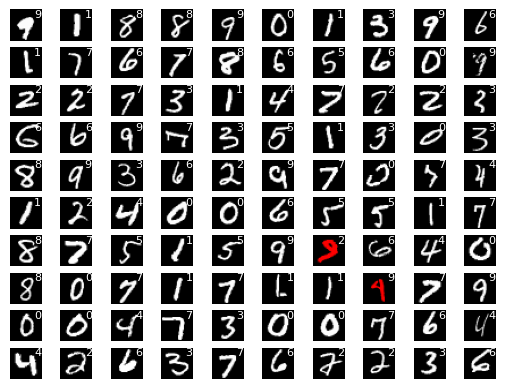

Accuracy:  0.982


In [24]:
def validate(model, data_loader):
    # TODO: Create a 10x10 grid of subplots
    fig, axe = plt.subplots(10, 10)
    axe = axe.flatten()
    model.eval()
    correct = 0 # count for correct predictions
    total = 0 # count total numbers of the images
    
    with torch.no_grad():
        for i, item in enumerate(data_loader):
            # TODO: unpack item into image and ground truth
            #       and run network on them
            image, label = item
            out = model(image)
            
            # TODO: get class with highest probability
            pred = out.argmax(dim = 1)
            
            # TODO: check if prediction is correct
            #       and add it to correct count
            correct += (pred == label).sum().item()
            total += label.size(0)
            
            # plot the first 100 images
            if i < 100:
                # TODO: compute position of ith image in the grid
                ax = axe[i]
                
                # TODO: convert image tensor to numpy array
                #       and normalize to [0, 1]
                img = image.squeeze().numpy()
                img = (img - img.min())/(img.max() - img.min())
                
                # TODO: make wrongly predicted images red
                if pred != label:
                    img = np.stack([img, np.zeros_like(img), np.zeros_like(img)], axis=-1)
                else:
                    img = np.stack([img, img, img], axis=-1)
                
                # TODO: disable axis and show image
                ax.axis('off')
                ax.imshow(img)
                
                # TODO: show the predicted class next to each image
                ax.text(1.0, 1.0, str(pred.item()), 
                        transform=ax.transAxes,
                        fontsize=8,
                        verticalalignment='top',
                        horizontalalignment='right', 
                        color = 'white')
            
            elif i == 100:
                plt.show()
    
    # TODO: compute and print the prediction accuracy in percent
    acc = correct / total
    print("Accuracy: ", acc)
    

# create a DataLoader using the implemented MNIST dataset class
data_loader = torch.utils.data.DataLoader(
    MNIST('data/mnist/testing',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=1, shuffle=True)

# create the neural network
model = Net()

# load the statedict from 'models/mnist/simple_cnn.pt'
model.load_state_dict(torch.load('models/mnist/simple_cnn.pt'))

# validate the model
validate(model, data_loader)